# AI & DL

## Лабораторная работа №2

### Выполнил: Инютин М. А.
### Группа: М8О-407Б-19

Необходимые библиотеки

In [1]:
import cv2
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

VOCSegmentation

In [2]:
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORS = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
)

VOC_COLORMAP = ListedColormap(VOC_COLORS / 255.0)


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(
        self, root="~/data/pascal_voc", image_set="train", download=True, transform=None
    ):
        super().__init__(
            root=root, image_set=image_set, download=download, transform=transform
        )

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORS)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORS):
            segmentation_mask[:, :, label_index] = np.all(
                mask == label, axis=-1
            ).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image, mask = torchvision.transforms.functional.to_tensor(
            image
        ), torch.from_numpy(mask)
        mask = mask.permute(2, 0, 1)
        return image, mask

Аугментация

In [3]:
from albumentations import (
    Compose,
    Flip,
    OneOf,
    PadIfNeeded,
    RandomBrightnessContrast,
    RandomCrop,
    RandomSizedCrop,
    Resize,
)

augs = Compose(
    [
        PadIfNeeded(448, 448),
        RandomBrightnessContrast(),
        OneOf(
            [RandomCrop(256, 256, p=0.2), RandomSizedCrop((224, 448), 256, 256)], p=1
        ),
    ]
)

val_augs = Compose([Resize(256, 256)])

Загрузка тренировочных и валидационных данных

In [4]:
PATH = "../data/"

train_dataset = PascalVOCSearchDataset(
    PATH, image_set="train", download=True, transform=augs
)
val_dataset = PascalVOCSearchDataset(
    PATH, image_set="val", download=True, transform=val_augs
)

Using downloaded and verified file: ../data/VOCtrainval_11-May-2012.tar
Extracting ../data/VOCtrainval_11-May-2012.tar to ../data/
Using downloaded and verified file: ../data/VOCtrainval_11-May-2012.tar
Extracting ../data/VOCtrainval_11-May-2012.tar to ../data/


Размеры датасетов и данных

In [5]:
print("Тренировочные данные", len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

print("Тестовые данные", len(val_dataset))
print(val_dataset[0][0].shape)
print(val_dataset[0][1].shape)

Тренировочные данные 1464
torch.Size([3, 256, 256])
torch.Size([21, 256, 256])
Тестовые данные 1449
torch.Size([3, 256, 256])
torch.Size([21, 256, 256])


In [6]:
def draw_samples(imgs, lbls):
    n = len(imgs)
    fig, ax = plt.subplots(n, 2, sharey=True, figsize=(2 * 3, n * 3))

    for i in range(n):
        ax[i, 0].imshow(imgs[i].permute(1, 2, 0))
        ax[i, 1].imshow(lbls[i].argmax(0), vmin=0, vmax=20, cmap=VOC_COLORMAP)

    for i in range(n):
        for j in range(2):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

Пример данных

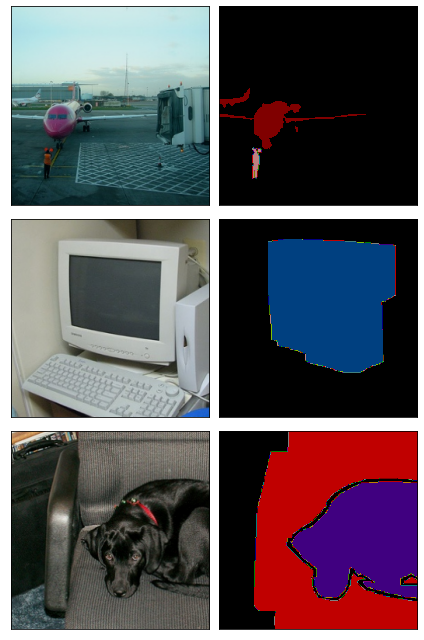

In [7]:
imgs, lbls = [], []

SAMPLES = 3
for i in range(SAMPLES):
    img, lbl = train_dataset[i]
    imgs.append(img)
    lbls.append(lbl)

draw_samples(imgs, lbls)

Dataloader с данными

In [8]:
CPU_CORES = 6
CPU_THREADS = 12
BATCH_SIZE = 8

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=CPU_CORES
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=CPU_CORES
)

train_n = len(train_dataloader)
val_n = len(val_dataloader)

Модель и функция ошибки

In [9]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

model = deeplabv3_mobilenet_v3_large(
    weights="DEFAULT", num_classes=len(VOC_CLASSES), progress=True
).cuda()

crit = torch.nn.CrossEntropyLoss(label_smoothing=1e-5)

Векторный расчёт метрик IoU и MIoU

In [10]:
IoU_EPS = 1e-6


def IoU(p, y):
    mask = p.softmax(1)
    cl = mask.argmax(1)
    cl_one_hot = torch.nn.functional.one_hot(cl, 21)
    cl_one_hot = torch.transpose(cl_one_hot, 1, 3)
    cl_one_hot = torch.transpose(cl_one_hot, 2, 3)

    iou_i = y * cl_one_hot
    iou_u = y + cl_one_hot

    s_i = iou_i.sum([2, 3])
    s_u = iou_u.count_nonzero([2, 3])
    return s_i / (s_u + IoU_EPS)


def MIoU(p, y):
    iou = IoU(p, y)
    return iou.sum(1) / (iou.count_nonzero(1) + IoU_EPS)

Обучение

In [11]:
DEBUG = False
EPOCHES = 5

h = {
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "epoches": list(range(1, EPOCHES + 1)),
}

optim = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)

for epoch in range(EPOCHES):
    train_s = "Training, epoch " + str(epoch + 1)
    train_loss_ep = 0

    cnt = 0
    model.train()
    for img, lbl in tqdm(train_dataloader, desc=train_s):
        img = img.cuda()
        lbl = lbl.cuda()
        p = model(img)["out"]
        loss = crit(p, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_loss_ep += loss.detach().cpu().item() / train_n
        if DEBUG and cnt > 10:
            break
        else:
            cnt += 1
    torch.cuda.empty_cache()

    val_s = "Validating, epoch " + str(epoch + 1)
    val_loss_ep = 0

    miou_ep = np.empty(shape=[0])
    cnt = 0
    model.eval()
    for img, lbl in tqdm(val_dataloader, desc=val_s):
        with torch.no_grad():
            img = img.cuda()
            lbl = lbl.cuda()
            p = model(img)["out"]
            loss = crit(p, lbl)
            val_loss_ep += loss.detach().cpu().item() / val_n
            miou_bc = MIoU(p, lbl).cpu().numpy()
            miou_ep = np.hstack((miou_ep, miou_bc))
            if DEBUG and cnt > 10:
                break
            else:
                cnt += 1
    torch.cuda.empty_cache()

    h["train_loss"].append(train_loss_ep)
    h["val_loss"].append(val_loss_ep)
    h["val_miou"].append(miou_ep.mean())

del optim

Validating, epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:55<00:00,  3.26it/s]


Визуализация результата

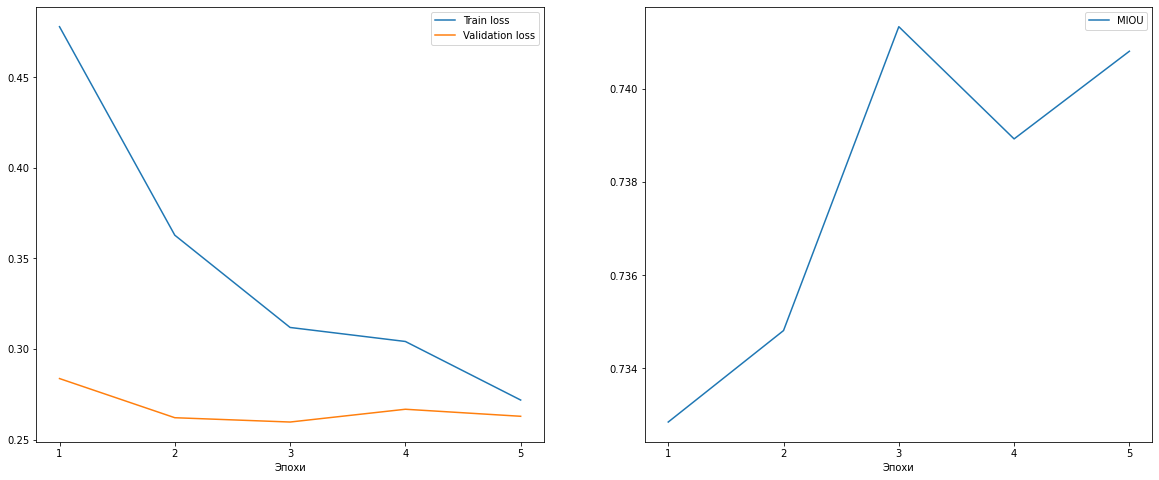

In [12]:
figure = plt.figure(figsize=(20, 8))

axes = figure.add_subplot(121)
plt.plot(h["epoches"], h["train_loss"], label="Train loss")
plt.plot(h["epoches"], h["val_loss"], label="Validation loss")
plt.xticks(h["epoches"])
plt.xlabel("Эпохи")
plt.legend()

axes = figure.add_subplot(122)
plt.plot(h["epoches"], h["val_miou"], label="MIOU")
plt.xticks(h["epoches"])
plt.xlabel("Эпохи")
plt.legend()
plt.show()

In [13]:
n_cl = len(VOC_CLASSES)

last_iou = np.zeros((n_cl,))
cnt = np.zeros((n_cl,))

iou_ind = []
ious = np.empty(shape=[0, 21])

model.eval()
for i, (img, lbl) in enumerate(tqdm(val_dataset, desc="Processing results")):
    pred = model(img.clone().detach().reshape((1, 3, 256, 256)).cuda())["out"]
    iou_i = IoU(pred, lbl.cuda())[0].detach().cpu().numpy()
    # pred_cl = np.unique(pred.cpu().softmax(1)[0].argmax(0))
    lbl_cl = np.unique(lbl.argmax(0))
    ious = np.vstack((ious, iou_i))

    lbl_cl_no_back = lbl_cl[1:]
    iou_ind.append([-iou_i[lbl_cl_no_back].mean(), i])

    cnt[lbl_cl] += 1
    last_iou[lbl_cl] += iou_i[lbl_cl]

    if i > 100 and DEBUG:
        break

last_iou /= cnt
sorted_inds = []
for iou, i in sorted(iou_ind):
    sorted_inds.append(i)

best_classes = ious.argmax(0)

Processing results: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1449/1449 [03:06<00:00,  7.78it/s]


In [14]:
def draw_preds(ids, s):
    n = len(ids)
    fig, ax = plt.subplots(n, 3, sharey=True, figsize=(3 * 3, n * 3))

    for i, elem in enumerate(ids):
        img = val_dataset[elem][0]
        lbl = val_dataset[elem][1]
        pred = (
            model(img.clone().detach().reshape((1, 3, 256, 256)).cuda())["out"]
            .cpu()
            .softmax(1)[0]
        )
        ax[i, 0].imshow(img.permute(1, 2, 0))
        ax[i, 1].imshow(pred.argmax(0), vmin=0, vmax=20, cmap=VOC_COLORMAP)
        ax[i, 2].imshow(lbl.argmax(0), vmin=0, vmax=20, cmap=VOC_COLORMAP)
    for i in range(n):
        for j in range(3):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
    plt.suptitle(s)
    plt.tight_layout()
    plt.show()

Среднее IoU на в развёртке по классам

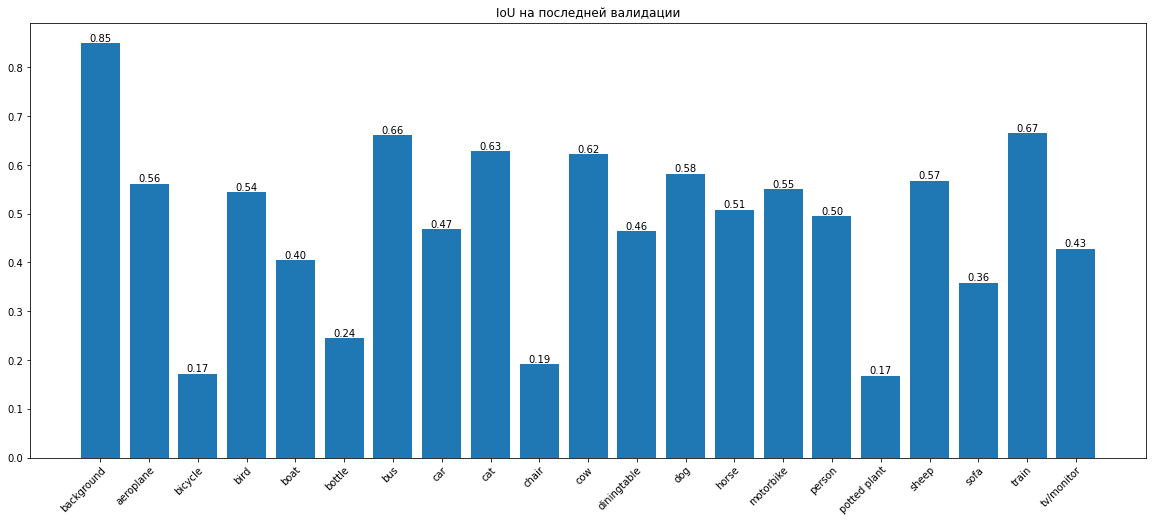

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_xticks(range(n_cl), labels=VOC_CLASSES)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("IoU на последней валидации")
bars = plt.bar(range(n_cl), last_iou)
plt.bar_label(bars, labels=[("%.2lf" % elem) for elem in last_iou])
plt.show()

Некоторые классы распознаются хуже других:

* велосипеды имеют низкие показатели из-за того, что сеть выделяет колесо в форме круга, а на данных оно выделено окружностью со спицами;
* кресла сеть часто путает с диванами, на некоторых фото видна только мебели, из-за чего даже мне не всегда понятно, диван это или кресло;
* растения сеть выделяет в виде большого пятна, а на данных выделены горшки, стебли и листья.

In [16]:
def best_from_sorted(l, r, k, s):
    n = len(sorted_inds)
    ids = np.random.choice(sorted_inds[int(l * n) : int(r * n)], k)
    draw_preds(ids, s)

Квантили

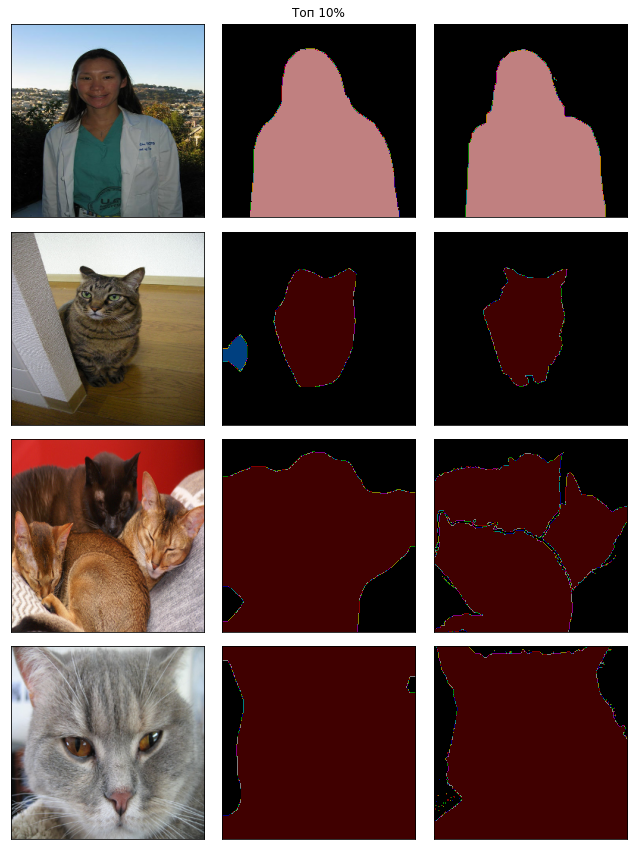

In [17]:
best_from_sorted(0.0, 0.1, 4, "Топ 10%")

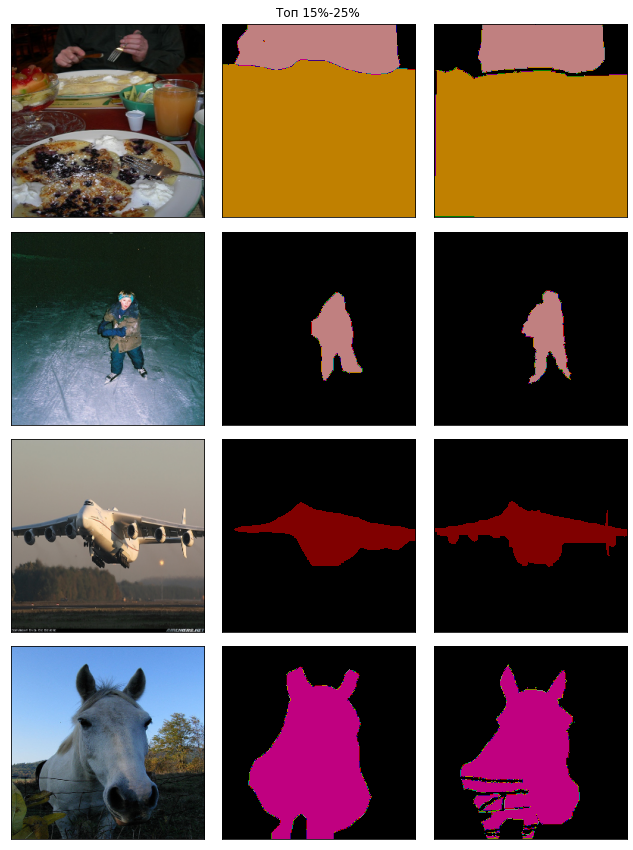

In [18]:
best_from_sorted(0.15, 0.25, 4, "Топ 15%-25%")

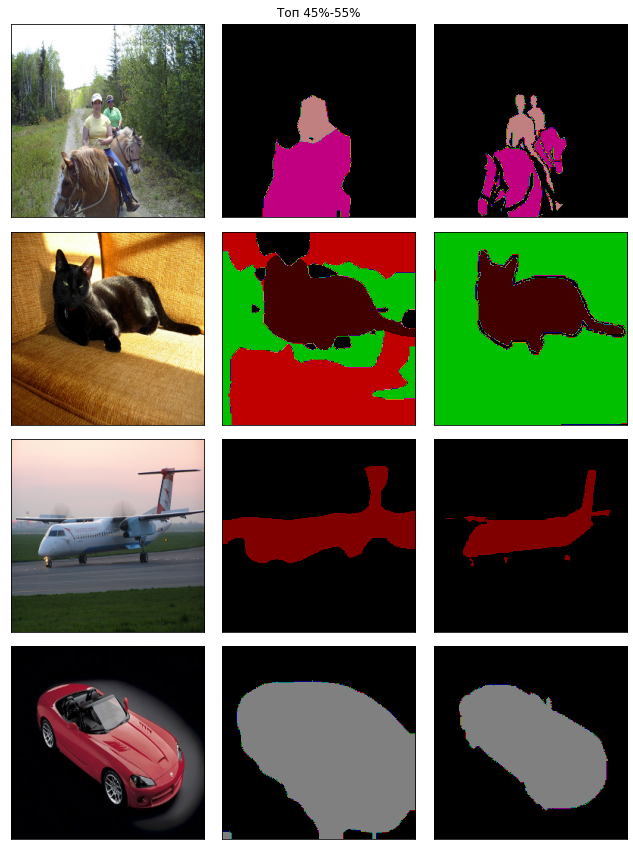

In [19]:
best_from_sorted(0.45, 0.55, 4, "Топ 45%-55%")

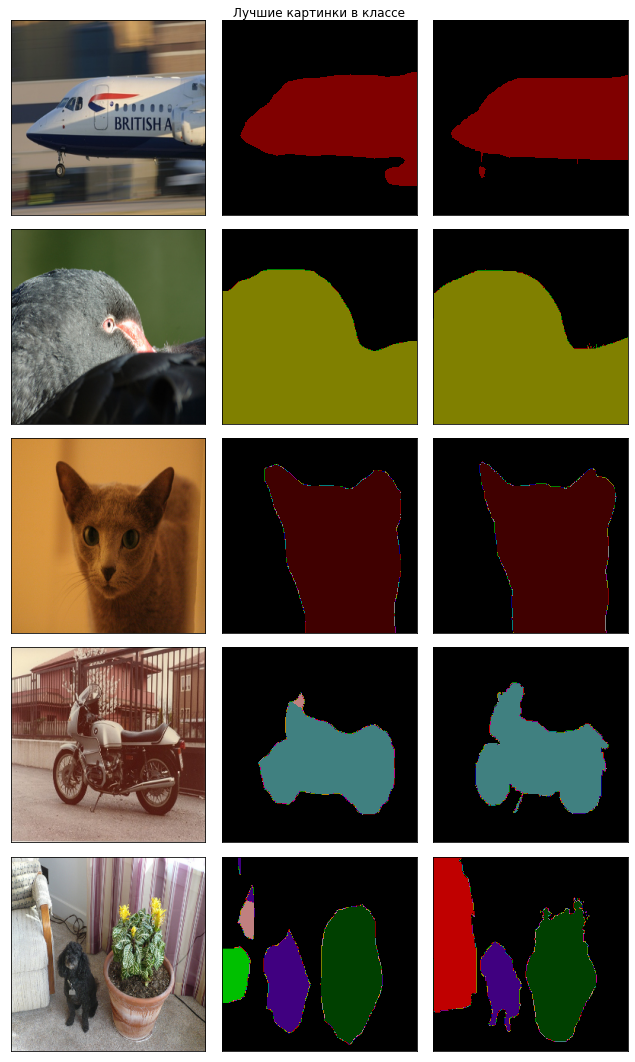

In [20]:
draw_preds(
    [
        best_classes[1],
        best_classes[3],
        best_classes[8],
        best_classes[14],
        best_classes[16],
    ],
    "Лучшие картинки в классе",
)